## Question and Hypothesis 
https://www.legalsportsreport.com/13243/ny-daily-fantasy-sports/

Every since monetary transactions in fantasy sports were legalized by New York in August of 2017, daily fantasy sports have generated approximately 335 million dollars per year. From the Fantasy Sports and Gaming Association’s (FSGA) 2019 survey, we learned that 50% of players were between the ages of 18 and 34, 64% were employed full time and 47% of players earn salaries of over \\$75,000 a year. Due to the attraction of the user base, our team statsketball decided to take a look into this fairly new industry allowing sports fan to place monetary bets. Our project explores the dataset we scraped below to predict the amount of FanDuel points NBA players will earn on a given night.  The question we want to answer is how well will a player perform on any given night based on their previous statistics.  We expect that players that perform better over the last couple of games will continue to do so, and we will evaluate this hypothesis by predicting the FanDuel points they will score based on the player and respective team's average statistics over the last 5 to 10 games.

### Ethical Concerns
There are ethical concerns regarding daily fantasy sports, in our case being FanDuel. The concept of daily fantasy sports can be seen as a method of gambling depending on the state involved. There are some that believe that the daily fantasy sports is more skill based on the user’s own knowledge on teams and players rather than a game of chance. 

In regards to the data, there may be ethical concerns based on where data is scraped from. Some websites may have regulations again scraping data from their website. In these cases, websites will provide a file “robots.txt” with their regulations on scraping from their website.

### Background and Data

We retrieved our dataset from NBA.com, which was publicly available. The data covers box scores that range from 2016 to 2019. This data set contains player boxscores (2016-2019 season), field goal percentage, fantasy points scored, player usage,  minutes played, as well as many other criteria for determining how many points a player will earn. FanDuel points are calclulated via the following formula: 1 * Points + 1.2 * Rebounds + 1.5 * Assists + 3 * (Blocks + Steals) - 1 * Turnovers. FanDuel works by giving you a $60,000 salary cap, which you spend on 9 different players: 2 Point Guards, 2 Shooting Guards, 2 Small Forwards, 2 Power Forwards, and 1 Center. Each player is given a salary, usually ranging from 3500 to 13000 based on how well they are predicted to perform. 

By predicting FanDuel points, we will be able to make optimal lineups for any given night, as well as predict the overall performance of a player using FanDuel points as our performance metric.
 

We can view a player’s performance on a night to night basis. This provides insights and confidence when FanDuel users select which players they want on their rosters.

Data from NBA: https://stats.nba.com/players/boxscores/?Season=2018-19&SeasonType=Regular%20Season

Data from rotoguru1: http://rotoguru1.com/cgi-bin/hyday.pl?game=fd&mon=10&day=25&year=2016

**Data Cleaning and Processing**

In [1]:
from selenium import webdriver
import json
import os.path
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import shutil
import re

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [16]:
# Download chrome webdriver here: https://chromedriver.storage.googleapis.com/index.html?path=79.0.3945.36/

driver = webdriver.Chrome('/Users/jordanlevy/Downloads/chromedriver') # change to your path for chromedriver
script_dir = '/Users/jordanlevy/Documents/GitHub/group078' # change to your script directory path

In [17]:
def dates_scraper(st_yr, end_yr):
    total_dates = pd.Series()
    for curr_yr in range(st_yr, end_yr+1):
        url = 'https://en.wikipedia.org/wiki/20{}-{}_NBA_season'.format(curr_yr, curr_yr+1)
        driver.get(url)
        yr_finder = driver.find_element_by_xpath('/html/body/div[3]/div[3]/div[4]/div/table[1]/tbody/tr[4]/td')
        reg_season = yr_finder.text.split('\n')[0]
        range_reg_season = reg_season.split(' – ')
        start_date = range_reg_season[0]
        end_date = range_reg_season[1]
        #print(reg_season)
        daterange = pd.Series(pd.date_range(start_date, end_date))
        total_dates = total_dates.append(daterange)
    return total_dates.reset_index(drop=True)

In [18]:
def download_roto_file(date):
    '''Downloads html file at the given url, which is rotoguru1.com with the corresponding month, day, and year
    from which to scrape data from. After writing all these webpages to a local html file, we will scrape the
    information needed and store it in a .csv file.  Takes about 21 minutes to scrape 3 seasons worth of data.'''
    url = 'http://rotoguru1.com/cgi-bin/hyday.pl?game=fd&mon={}&day={}&year={}'.format(date.month, date.day, date.year)
    driver.get(url)
    print('Got url:',str(date)[:10])
    
    soup = BeautifulSoup(driver.page_source, 'html5lib')

    json = soup.findAll('table')
    data = json[9]

    date_str = str(date)[:10]
    local_filename = 'data/Roto_Data/Roto_html/roto_data_{}.html'.format(date_str)
    with open(local_filename, 'w') as f:

        for row in data:
            #print(row)

            f.write(str(row))

In [19]:
def scrape_roto_data(date):
    '''After writing all webpages from rotoguru1.com into local .html files, this function scrapes and cleans useful
    information from the file using Beautiful Soup, namely the player name, date, minutes played, and salary for that
    date.  Once done extracting information from one date, writes to a .csv file from a Pandas dataframe for later
    access.'''
    date_str = str(date)[:10]

    local_filename = 'data/Roto_Data/Roto_html/roto_data_{}.html'.format(date_str)
    data= BeautifulSoup(open(local_filename))#,'html.parser')
    
    trs = data.findAll('tr')
    if len(trs) == 0:
        return None
    tds = [tr.findAll('td') for tr in trs]
    player_data = [tr.text for tr in trs]
    pattern = '[A-Za-z]+, [A-Za-z]+'
    prog = re.compile(pattern)
    player_data_alt = [player[2:] if player[0] != 'C' else player[1:] for player in player_data]
    player_names = [re.search(pattern, player.replace('.','')).group(0).strip(' ') for player in player_data_alt if re.search(pattern, player.replace('.',''))]
    td_data = [pd.Series(td).apply(lambda x: x.text) for td in tds if len(td) ==9]
    player_df = pd.DataFrame(td_data)#.apply(lambda x: x.apply(lambda y: y.text))
    player_df['LastName, FirstName'] = player_names
    player_data_df = player_df.drop([1],axis=1)
    cols = ['Position', 'FD PTS', 'Salary', 'Team', 'Opp Team', 'Score', 'Min', 'Statline', 'LastName, FirstName']
    player_data_df.columns = cols
    
    player_data_df['Date'] = [date_str for _ in range(len(player_data_df['Position']))]
    new_cols = ['Date', 'Position', 'LastName, FirstName', 'FD PTS', 'Salary', 'Team', 'Opp Team', 'Score', 'Min', 'Statline']
    player_data_df = player_data_df[new_cols]
    player_data_df['Salary'] = player_data_df['Salary'].str.strip('$')
    player_data_df['Min'] = player_data_df['Min'].str.replace('DNP','0').replace('NA','0')
    player_data_df.to_csv('data/Roto_Data/Roto_csv/roto_data_{}.csv'.format(date_str), index=False)
    

In [20]:
%%time
total_dates = dates_scraper(16, 19) # Scrapes start and end dates of regular season from 16-17 to 18-19 NBA Seasons

CPU times: user 22.1 ms, sys: 6.73 ms, total: 28.9 ms
Wall time: 2.6 s


In [21]:
len(total_dates)

701

Download all rotoguru webpages that are in the range of dates.  In our case this is every date from the 16-17 to 18-19
NBA Seasons.

In [1054]:
%%time
total_dates.apply(download_roto_file)

Got url: 2019-10-22
Got url: 2019-10-23
Got url: 2019-10-24
Got url: 2019-10-25
Got url: 2019-10-26
Got url: 2019-10-27
Got url: 2019-10-28
Got url: 2019-10-29
Got url: 2019-10-30
Got url: 2019-10-31
Got url: 2019-11-01
Got url: 2019-11-02
Got url: 2019-11-03
Got url: 2019-11-04
Got url: 2019-11-05
Got url: 2019-11-06
Got url: 2019-11-07
Got url: 2019-11-08
Got url: 2019-11-09
Got url: 2019-11-10
Got url: 2019-11-11
Got url: 2019-11-12
Got url: 2019-11-13
Got url: 2019-11-14
Got url: 2019-11-15
Got url: 2019-11-16
Got url: 2019-11-17
Got url: 2019-11-18
Got url: 2019-11-19
Got url: 2019-11-20
Got url: 2019-11-21
Got url: 2019-11-22
Got url: 2019-11-23
Got url: 2019-11-24
Got url: 2019-11-25
Got url: 2019-11-26
Got url: 2019-11-27
Got url: 2019-11-28
Got url: 2019-11-29
Got url: 2019-11-30
Got url: 2019-12-01
Got url: 2019-12-02
Got url: 2019-12-03
Got url: 2019-12-04
Got url: 2019-12-05
Got url: 2019-12-06
Got url: 2019-12-07
Got url: 2019-12-08
Got url: 2019-12-09
Got url: 2019-12-10



KeyboardInterrupt



We then extract all useful information from the files we just wrote to .html, as stated in the scrape_roto_data docstring.

In [1055]:
%%time
total_dates.apply(scrape_roto_data)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Roto_Data/Roto_html/roto_data_2019-12-22.html'

The below function simply combines all of the csv files we created in the above cell.

In [22]:
def comb_roto_data(dates):
    total_data = pd.DataFrame()
    for date in dates:
        fname = 'data/Roto_Data/Roto_csv/roto_data_{}-{}-{}.csv'.format(str(date.year).zfill(2), str(date.month).zfill(2), str(date.day).zfill(2))
        try:
            total_data = total_data.append(pd.read_csv(fname))
        except FileNotFoundError:
            continue
    return total_data.reset_index(drop=True)

We store the output of comb_roto_data, a Pandas dataframe, into a variable called roto_data.

In [23]:
%%time
roto_data = comb_roto_data(total_dates)

CPU times: user 31.3 s, sys: 2.74 s, total: 34 s
Wall time: 35.2 s


In [24]:
roto_data

,Date,Position,"LastName, FirstName",FD PTS,Salary,Team,Opp Team,Score,Min,Statline
0,2016-10-25,PG,"Lillard, Damian",54.8,"8,900",por,v uta,113-104,35:25,39pt 9rb 6as 4to 4trey 13-20fg 9-9ft
1,2016-10-25,PG,"Irving, Kyrie",41.4,"7,100",cle,v nyk,117-88,29:48,29pt 2rb 4as 2st 4trey 12-22fg 1-1ft
2,2016-10-25,SG,"Hood, Rodney",35.9,"5,400",uta,@ por,104-113,37:39,26pt 2rb 1as 2st 1bl 3trey 9-17fg 5-5ft
3,2016-10-25,PG,"Hill, George",35.4,"5,600",uta,@ por,104-113,38:45,19pt 2rb 6as 2st 1bl 1to 1trey 7-18fg 4-4ft
4,2016-10-25,PG,"Curry, Stephen",31.6,"9,300",gsw,v sas,100-129,34:06,26pt 3rb 4as 4to 3trey 9-18fg 5-6ft
...,...,...,...,...,...,...,...,...,...,...
128173,2019-12-16,C,"Ayton, Deandre",0.0,"3,500",pho,v por,110-111,0,
128174,2019-12-16,C,"Bryant, Thomas",0.0,"6,300",was,@ det,133-119,0,
128175,2019-12-16,C,"Patton, Justin",0.0,"3,500",okc,v chi,109-106,0,
128176,2019-12-16,C,"Wagner, Moritz",0.0,"6,000",was,@ det,133-119,0,


Write to csv for later access.

In [25]:
roto_data.to_csv('data/Roto_Data/roto_total_data.csv',index=False)

In [26]:
roto_data = pd.read_csv('data/Roto_Data/roto_total_data.csv')

Below is the output of all the information we scraped from the rotoguru webpages.

In [27]:
roto_data

,Date,Position,"LastName, FirstName",FD PTS,Salary,Team,Opp Team,Score,Min,Statline
0,2016-10-25,PG,"Lillard, Damian",54.8,"8,900",por,v uta,113-104,35:25,39pt 9rb 6as 4to 4trey 13-20fg 9-9ft
1,2016-10-25,PG,"Irving, Kyrie",41.4,"7,100",cle,v nyk,117-88,29:48,29pt 2rb 4as 2st 4trey 12-22fg 1-1ft
2,2016-10-25,SG,"Hood, Rodney",35.9,"5,400",uta,@ por,104-113,37:39,26pt 2rb 1as 2st 1bl 3trey 9-17fg 5-5ft
3,2016-10-25,PG,"Hill, George",35.4,"5,600",uta,@ por,104-113,38:45,19pt 2rb 6as 2st 1bl 1to 1trey 7-18fg 4-4ft
4,2016-10-25,PG,"Curry, Stephen",31.6,"9,300",gsw,v sas,100-129,34:06,26pt 3rb 4as 4to 3trey 9-18fg 5-6ft
...,...,...,...,...,...,...,...,...,...,...
128173,2019-12-16,C,"Ayton, Deandre",0.0,"3,500",pho,v por,110-111,0,
128174,2019-12-16,C,"Bryant, Thomas",0.0,"6,300",was,@ det,133-119,0,
128175,2019-12-16,C,"Patton, Justin",0.0,"3,500",okc,v chi,109-106,0,
128176,2019-12-16,C,"Wagner, Moritz",0.0,"6,000",was,@ det,133-119,0,


Next we scrape a dictionary that gives every NBA players a corresponding player ID.  This will be important when connecting different datasets from nba.com, as any dataset referencing NBA players will use 'playerID' to uniquely identify each player.  Thus we will easily be able to join different datasets on 'playerID'.

In [28]:
def player_dictionary():
    '''
    Data source: https://any-api.com/nba_com/nba_com/console/_commonallplayers/GET
    Actual URL: (https://stats.nba.com/stats/commonallplayers?LeagueID=00&Season=2019-20&IsOnlyCurrentSeason=0)
    Resource: https://any-api.com:8443/https://stats.nba.com/stats/commonallplayers?LeagueID=00&Season=2019-20&IsOnlyCurrentSeason=0
    '''
    with open('data/totalPlayerIDs.json') as f:
        j = json.loads(f.read())
        headers = j['resultSets'][0]['headers']
        player_ids = j['resultSets'][0]['rowSet']
        nba_players = pd.DataFrame(player_ids, columns=headers)
        nba_players.to_csv('data/NBA_Player_Dictionary.csv', index=False)
    return pd.read_csv('data/NBA_Player_Dictionary.csv')

In [29]:
player_dict_df = player_dictionary()

In [30]:
#player_dict_df.to_csv('data/NBA_Player_Dictionary.csv', index=False)

We then scrape player and team boxscores, as well as player bios by using the following function.  As an additional note, I was able to scrape this data by copy and pasting the json for each table under the Network tab of developer tools on stats.nba.com for each of the nba.com datasets (3 in total).

In [31]:
def nba_boxscores(fname, st_yr, end_yr):
    df = pd.DataFrame()
    yr_dict = {i:'22'+str(i).zfill(3) for i in range(st_yr, end_yr+1)}
    for yr in range(st_yr, end_yr+1):
        curr_yr, next_yr = yr, yr+1
        with open('data/NBA_boxscores/'+fname+'{}-{}.json'.format(curr_yr, next_yr)) as f:
            k = json.loads(f.read())
            yr_data = pd.DataFrame(k['resultSets'][0]['rowSet'], columns=k['resultSets'][0]['headers'])
            if 'Bio' in fname:
                yr_data['SEASON_ID'] = yr_dict[curr_yr]
            #print(yr_data)
            df = df.append(yr_data)
    return df

As you can see, the above function takes a filename, start, and end year, thus making it easy to scrape different datasets that follow a similar naming convention.

**TODO: Make a function to scrape all team and player boxscores for that year, save to playerData{}-{}.json and teamData{}-{}.json** 

In [32]:
%%time
player_fname = 'playerData'
team_fname = 'teamData'
NBA_player_data = nba_boxscores(player_fname, 16, 19).reset_index(drop=True)
NBA_team_data = nba_boxscores(team_fname, 16, 19).reset_index(drop=True)
NBA_player_bios = nba_boxscores('playerBios', 16, 19).reset_index(drop=True)

CPU times: user 3.96 s, sys: 272 ms, total: 4.23 s
Wall time: 2.5 s


/Users/jordanlevy/Desktop/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


The following function combines the roto_data and NBA_player_data dataframes, which was arguably the most difficult process in the data cleaning process.  This is because were hundreds of names between stats.nba.com and rotoguru1.com that did not perfectly match.  For example, one site would have 'J.R. Smith', while the other site had 'JR Smith'.  I had to create a missing_players function to map player names that were inconsistent between the two sites.  I switched all names to the stats.nba.com datasets as we were using more data from that site than rotoguru1.com.  Most of the names were fixed pretty easily by stripping periods from names or checking if one name was a subset of the other; but some names I ended up changing manually as there were a couple unpredictable inconsistencies.  Once I fix all the names, I merge the two datasets by the unique keys for each row from both datasets, which is playerID and Game Date.

In [33]:
def roto_nba_combine(NBA_data, roto_data, player_dict_df):
    player_dict = dict(zip(player_dict_df['DISPLAY_LAST_COMMA_FIRST'], player_dict_df['PERSON_ID']))
    player_ids = roto_data['LastName, FirstName'].apply(lambda x: [player_dict[x] if x in player_dict else x][0])
    corr_names = missing_players(roto_data, player_ids, player_dict)
    roto_data['LastName, FirstName'] = roto_data['LastName, FirstName'].replace(corr_names)
    player_ids = roto_data['LastName, FirstName'].apply(lambda x: [player_dict[x] if x in player_dict else ''][0])
    roto_data['NBA_ID'] = player_ids
    
    return roto_data.merge(NBA_data, how='inner', left_on=['NBA_ID', 'Date'], right_on=['PLAYER_ID','GAME_DATE'])
    
    
    

In [34]:
def missing_players(roto_data, player_ids, player_dict):
    '''Returns a dictionary of the names to correct from the roto dataset to NBA.  Update this as needed'''
    players_not_found = roto_data[player_ids.str.isdigit() == False]
    corr_names = {}
    for name in players_not_found['LastName, FirstName'].unique():
        for key in player_dict.keys():
            names = name.split(',')
            if (names[0] in key and names[1] in key):
                corr_names[name] = key
    players_not_found = list(set(players_not_found['LastName, FirstName'].unique()) - set(corr_names.keys()))
    name_pattern = '[A-Z]{2}'
    name_prog = re.compile(name_pattern)
    players_not_found = [re.sub(name_prog, p_name[-2]+'.'+p_name[-1]+'.',p_name) for p_name in players_not_found]
    for name in players_not_found:
        for key in player_dict.keys():
            names = name.split(',')
            if (names[0] in key and names[1] in key):
                corr_names[name] = key
    corr_names['Williams, Louis'] = 'Williams, Lou'
    corr_names['Jr, Walter'] = 'Lemon Jr., Walt'
    corr_names['Hernangomez, Guillermo'] = 'Hernangomez, Willy'
    corr_names['Long, Nazareth'] = 'Mitrou-Long Naz'
    corr_names['o.b.I, Jacob'] = 'Evans, Jacob'
    corr_names['Bamba, Mohamed'] = 'Bamba, Mo'
    corr_names['n.k.I, Frank'] = 'Mason, Frank'
    corr_names['Smith, Ishmael'] = 'Smith, Ish'
    corr_names['Mykhailiuk, Sviatoslav'] = 'Mykhailiuk, Svi'
    corr_names['Barea, Jose'] = 'Barea, J.J.'
    corr_names['Hilario, Nene'] = 'Nene'
    return corr_names
    

We saved the output of the combine function into a variable that is a Pandas dataframe.

In [35]:
%%time
nba_roto_data = roto_nba_combine(NBA_player_data, roto_data, player_dict_df)

CPU times: user 1.44 s, sys: 84.7 ms, total: 1.53 s
Wall time: 1.44 s


The following function cleans some of the combined dataset by converting Salary from a string to an integer by stripping commas, and creating a binary column for whether or not the player's team played at home (1 means they were home, 0 for away).  We then drop unnecessary columns from the dataframe.

In [36]:
def nba_roto_clean(df):
    df['Salary'] = df['Salary'].str.replace(',','').fillna(0).astype(int)
    df['Home?'] = df['MATCHUP'].apply(lambda x: x.split(' ')[1]).map({'vs.':1,'@':0}).astype(int)
    df = df.drop(['Team', 'Opp Team', 'Score', 'Statline', 'Min'], axis=1)
    
    return df

In [37]:
clean_nba_roto = nba_roto_clean(nba_roto_data)

Here is what our combined dataframe looks like so far:

In [38]:
clean_nba_roto

,Date,Position,"LastName, FirstName",FD PTS,Salary,NBA_ID,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home?
0,2016-10-25,PG,"Lillard, Damian",54.8,8900,203081,22016,203081,Damian Lillard,1610612757,...,1,8,9,6,0,0,4,3,1,1
1,2016-10-25,PG,"Irving, Kyrie",41.4,7100,202681,22016,202681,Kyrie Irving,1610612739,...,1,1,2,4,2,0,0,1,13,1
2,2016-10-25,SG,"Hood, Rodney",35.9,5400,203918,22016,203918,Rodney Hood,1610612762,...,0,2,2,1,2,1,0,3,5,0
3,2016-10-25,PG,"Hill, George",35.4,5600,201588,22016,201588,George Hill,1610612762,...,0,2,2,6,2,1,1,2,2,0
4,2016-10-25,PG,"Curry, Stephen",31.6,9300,201939,22016,201939,Stephen Curry,1610612744,...,0,3,3,4,0,0,4,1,-9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67509,2019-12-16,C,"Lopez, Brook",11.0,5300,201572,22019,201572,Brook Lopez,1610612749,...,1,4,5,2,0,0,1,1,-9,1
67510,2019-12-16,C,"Olynyk, Kelly",8.1,4200,203482,22019,203482,Kelly Olynyk,1610612748,...,0,3,3,1,0,1,0,3,-6,0
67511,2019-12-16,C,"Poeltl, Jakob",7.9,4200,1627751,22019,1627751,Jakob Poeltl,1610612759,...,1,1,2,3,0,0,1,1,8,0
67512,2019-12-16,C,"Lopez, Robin",0.0,3900,201577,22019,201577,Robin Lopez,1610612749,...,0,0,0,0,0,0,0,0,-7,1


After cleaning the combined player boxscores and rotoguru data, we will combine the dataframe with the player's corresponding team boxscore for that game.  This is done by finding the set difference between the team boxscores dataframe and the cleaned combined dataframe, then merging the two on 'GAME_ID' and 'TEAM_ID'.

In [39]:
cols_to_use_team = list(NBA_team_data.columns.difference(clean_nba_roto.columns))
cols_to_use_team.append('GAME_ID')
cols_to_use_team.append('TEAM_ID')

In [40]:
player_team_combined = clean_nba_roto.merge(NBA_team_data[cols_to_use_team], on=['GAME_ID', 'TEAM_ID'])

We have now joined advanced team stats from each game to player boxscores for that game.  This will give us a better picture of how the team around the player performed in each game.

In [41]:
player_team_combined.columns

Index(['Date', 'Position', 'LastName, FirstName', 'FD PTS', 'Salary', 'NBA_ID',
       'SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'Home?', 'AST_PCT', 'AST_PCT_RANK', 'AST_RATIO',
       'AST_RATIO_RANK', 'AST_TO', 'AST_TO_RANK', 'DEF_RATING',
       'DEF_RATING_RANK', 'DREB_PCT', 'DREB_PCT_RANK', 'EFG_PCT',
       'EFG_PCT_RANK', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING',
       'E_PACE', 'GP_RANK', 'L_RANK', 'MIN_RANK', 'NET_RATING',
       'NET_RATING_RANK', 'OFF_RATING', 'OFF_RATING_RANK', 'OREB_PCT',
       'OREB_PCT_RANK', 'PACE', 'PACE_PER40', 'PACE_RANK', 'PIE', 'PIE_RANK',
       'POSS', 'REB_PCT', 'REB_PCT_RANK', 'SEASON_YEAR', 'TM_TOV_PCT',
       'TM_TOV_PCT_RANK', 'TS_PCT', 'TS_PCT_RANK', 'W_PCT_RANK',

We drop columns ending in '_RANK' as we found them to be redundant.

In [42]:
player_team_combined = player_team_combined.drop([i for i in player_team_combined.columns if '_RANK' in i], axis=1)

As we prepare to add player bios to the dataset, we drop redundant or unnecessary columns from NBA_player_bios.

In [43]:
NBA_player_bios = NBA_player_bios.drop(['COLLEGE', 'DRAFT_YEAR','COUNTRY', 'PLAYER_HEIGHT'],axis=1)

In [44]:
NBA_player_bios = NBA_player_bios.drop(NBA_player_bios.columns[9:-1],axis=1)

We then merge player bios with the combined player and team boxscores dataframe by their common unique keys: 'PLAYER_ID' and 'SEASON_ID'.

In [45]:
cols_to_use = list(NBA_player_bios.columns.difference(player_team_combined.columns))
cols_to_use.append('PLAYER_ID')
cols_to_use.append('SEASON_ID')

In [46]:
%%time
player_team_bios = player_team_combined.merge(NBA_player_bios[cols_to_use], on=['PLAYER_ID','SEASON_ID'])

CPU times: user 488 ms, sys: 66.7 ms, total: 554 ms
Wall time: 560 ms


In [47]:
player_team_bios = player_team_bios.drop(['NBA_ID'], axis=1)

Here is now what our total dataframe looks like:

In [48]:
player_team_bios

,Date,Position,"LastName, FirstName",FD PTS,Salary,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,...,POSS,REB_PCT,SEASON_YEAR,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,DRAFT_ROUND,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT
0,2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,...,92.0,0.500,2016-17,0.141,0.667,26.0,6,1,75,195
1,2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,...,NaN,NaN,NaN,NaN,NaN,26.0,6,1,75,195
2,2016-10-27,PG,"Lillard, Damian",41.5,9100,22016,203081,Damian Lillard,1610612757,POR,...,102.0,0.509,2016-17,0.137,0.535,26.0,6,1,75,195
3,2016-10-27,PG,"Lillard, Damian",41.5,9100,22016,203081,Damian Lillard,1610612757,POR,...,NaN,NaN,NaN,NaN,NaN,26.0,6,1,75,195
4,2016-10-29,PG,"Lillard, Damian",56.5,9100,22016,203081,Damian Lillard,1610612757,POR,...,115.0,0.434,2016-17,0.139,0.536,26.0,6,1,75,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126803,2019-12-14,SG,"Dort, Luguentz",2.7,3500,22019,1629652,Luguentz Dort,1610612760,OKC,...,NaN,NaN,NaN,NaN,NaN,20.0,Undrafted,Undrafted,75,215
126804,2019-12-08,SG,"Horton-Tucker, Talen",1.5,3500,22019,1629659,Talen Horton-Tucker,1610612747,LAL,...,NaN,NaN,NaN,NaN,NaN,19.0,46,2,76,234
126805,2019-12-08,PF,"Reid, Naz",3.0,3500,22019,1629675,Naz Reid,1610612750,MIN,...,NaN,NaN,NaN,NaN,NaN,20.0,Undrafted,Undrafted,81,264
126806,2019-12-09,PF,"Reid, Naz",1.2,3500,22019,1629675,Naz Reid,1610612750,MIN,...,NaN,NaN,NaN,NaN,NaN,20.0,Undrafted,Undrafted,81,264


We wanted to derive BMI of a player from the player's weight and height, so we had to change the dtype of 'PLAYER_WEIGHT' from object to integer.

In [49]:
player_team_bios['PLAYER_WEIGHT'].dtype

dtype('O')

In [50]:
player_team_bios['PLAYER_WEIGHT'] = player_team_bios['PLAYER_WEIGHT'].astype(int)

In [51]:
player_team_bios['BMI'] = player_team_bios['PLAYER_WEIGHT']/(player_team_bios['PLAYER_HEIGHT_INCHES'] ** 2) * 703 

In [52]:
player_team_bios = player_team_bios.set_index('Date')#.sort_index()

In [53]:
player_team_bios = player_team_bios.sort_index()

The below cells create an import feature we will later use in our model.  Basically, we wanted to come up with features that we could realistically know before the player's game begins.  We decided to compute the rolling averages of the past 5 games for several different player and team statistics.  Implementing this proved to be a bit tricky, as we had to create a Game_ID for each row, which represents the number game that player has played in the dataset, sorted by ascending date.  For example, a player's first game played in this dataset, which contains the last 3 NBA seasons, is given a 'PLAYER_GAME_ID' of 0.  The next game they play would be assigned an id of 1, and so on.

We then create player_groups, whichTo actually implement this, we first group the dataframe by player id, and create a dictionary with a player_id assigned to a dictionary of index values assigned to its corresponding 'PLAYER_GAME_ID' value.  This is implemented in player_groups.

In [54]:
player_groups = player_team_bios.groupby('PLAYER_ID').apply(lambda x: dict(zip(x.index,range(0,len(x.index)))))

In [55]:
#player_groups = player_team_bios.groupby('PLAYER_ID').apply(lambda x: (game_dates_by_player[pd.Series(x['PLAYER_ID'].values).unique()[0]]))

In [56]:
player_groups

PLAYER_ID
1713       {'2016-10-26': 1, '2016-10-29': 3, '2016-10-30...
1717       {'2016-10-26': 1, '2016-11-02': 3, '2016-11-04...
1718       {'2016-11-29': 1, '2016-12-01': 3, '2016-12-20...
1891       {'2016-10-26': 1, '2016-11-03': 3, '2016-11-06...
1897                      {'2017-04-05': 1, '2017-04-11': 3}
                                 ...                        
1629741    {'2019-10-23': 0, '2019-10-25': 1, '2019-10-27...
1629742    {'2019-10-25': 0, '2019-10-26': 1, '2019-10-30...
1629744    {'2019-10-26': 0, '2019-10-30': 1, '2019-11-02...
1629750    {'2019-10-25': 0, '2019-10-26': 1, '2019-10-30...
1629752    {'2019-11-27': 0, '2019-12-07': 1, '2019-12-09...
Length: 749, dtype: object

After creating player groups, we do some fancy indexing to update the main dataframe.

In [57]:
%%time
player_team_bios['PLAYER_GAME_ID'] = player_team_bios.apply(lambda row: player_groups[int(row['PLAYER_ID'])][row.name], axis=1)

CPU times: user 4.23 s, sys: 139 ms, total: 4.37 s
Wall time: 4.45 s


We created a copy of player_team_bios and called it master_dataset, as this has all the data we will be using.

In [58]:
master_dataset = player_team_bios.copy()

In [59]:
master_dataset['PLAYER_GAME_ID']

Date
2016-10-25      1
2016-10-25      1
2016-10-25      1
2016-10-25      1
2016-10-25      1
             ... 
2019-12-16     43
2019-12-16    355
2019-12-16    491
2019-12-16    292
2019-12-16    473
Name: PLAYER_GAME_ID, Length: 126808, dtype: int64

In [60]:
player_team_bios

,Position,"LastName, FirstName",FD PTS,Salary,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,...,SEASON_YEAR,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,DRAFT_ROUND,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,BMI,PLAYER_GAME_ID
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-25,PG,"Lillard, Damian",54.8,8900,22016,203081,Damian Lillard,1610612757,POR,Portland Trail Blazers,...,2016-17,0.141,0.667,26.0,6,1,75,195,24.370667,1
2016-10-25,SF,"Anderson, Kyle",9.8,3500,22016,203937,Kyle Anderson,1610612759,SAS,San Antonio Spurs,...,NaN,NaN,NaN,23.0,30,1,81,230,24.644109,1
2016-10-25,SF,"Anderson, Kyle",9.8,3500,22016,203937,Kyle Anderson,1610612759,SAS,San Antonio Spurs,...,2016-17,0.140,0.589,23.0,30,1,81,230,24.644109,1
2016-10-25,SF,"Simmons, Jonathon",29.3,3500,22016,203613,Jonathon Simmons,1610612759,SAS,San Antonio Spurs,...,NaN,NaN,NaN,27.0,Undrafted,Undrafted,78,195,22.532051,1
2016-10-25,SF,"Simmons, Jonathon",29.3,3500,22016,203613,Jonathon Simmons,1610612759,SAS,San Antonio Spurs,...,2016-17,0.140,0.589,27.0,Undrafted,Undrafted,78,195,22.532051,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-16,SG,"Mykhailiuk, Svi",12.7,3500,22019,1629004,Svi Mykhailiuk,1610612765,DET,Detroit Pistons,...,NaN,NaN,NaN,22.0,47,2,79,205,23.091652,43
2019-12-16,C,"Thompson, Tristan",31.1,7300,22019,202684,Tristan Thompson,1610612739,CLE,Cleveland Cavaliers,...,NaN,NaN,NaN,28.0,4,1,81,254,27.215668,355
2019-12-16,PG,"Westbrook, Russell",50.0,10400,22019,201566,Russell Westbrook,1610612745,HOU,Houston Rockets,...,NaN,NaN,NaN,31.0,4,1,75,200,24.995556,491


In [61]:
master_dataset = master_dataset.reset_index()

We replace 'Undrafted' with draft number 61 so that we can convert the column to integer dtype.

In [62]:
master_dataset['DRAFT_NUMBER'] = master_dataset['DRAFT_NUMBER'].replace('Undrafted', 61).astype(int)

We drop columns we don't need.

In [63]:
player_found_dataset = master_dataset.drop([i for i in master_dataset.columns if str(master_dataset[i].dtype) not in ['int64', 'float64']], axis=1)

cols_lst = ['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'BMI']
for col in range(4,len(player_found_dataset.columns)-2):
    
    cols_lst.append(player_found_dataset.columns[col])
cols_lst.append('FD PTS')
cols_lst.append('BMI')
player_found_dataset = player_found_dataset[cols_lst]

Our default dataset contains features that we want to include in our feature dataset, but that we are not computing rolling averages for, or we include them in addition to their rolling averages.

In [64]:
player_found_dataset.columns

Index(['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'BMI', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING',
       'DREB_PCT', 'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING',
       'E_PACE', 'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40',
       'PIE', 'POSS', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'AGE', 'DRAFT_NUMBER',
       'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'FD PTS', 'BMI'],
      dtype='object')

In [65]:
default_dataset = master_dataset[['PLAYER_ID','TEAM_ID','SEASON_ID','PLAYER_GAME_ID', 'Salary', 'MIN', 'AGE', \
                                        'DRAFT_NUMBER', 'BMI', 'Home?']]

The following columns are quantitative columns that we want to standardize.

In [66]:
toScaled = player_found_dataset[['Salary', 'MIN', 'PTS', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING', 'DREB_PCT',
       'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING', 'E_PACE',
       'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40', 'PIE',
       'POSS', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'FD PTS']]

In [67]:
sc = StandardScaler()

In [68]:
standardize_dataset

NameError: name 'standardize_dataset' is not defined

In [69]:
standardize_dataset['PLAYER_GAME_ID'] = player_found_dataset['PLAYER_GAME_ID']
standardize_dataset['Position'] = master_dataset['Position']

NameError: name 'standardize_dataset' is not defined

total_rolling_avgs_col takes in a dataframe, column name, and the size by which to average by, and uses the Pandas rolling function to create rolling averages of the last 'avg_size' games for the given column name, grouped by 'PLAYER_ID'.

In [70]:
def total_rolling_avgs_col(df, group_by, col_name, avg_size):
    rolling_avgs = df.groupby(group_by)[col_name].rolling(avg_size).mean()
    for i in range(avg_size-1, -1, -1):
        rolling_avgs = rolling_avgs.fillna(df.groupby(group_by)[col_name].rolling(i).mean())
    return rolling_avgs

roll_avgs_col_maker essentially adds the output of total_rolling_avgs_col to the total dataframe.

In [71]:
def roll_avgs_col_maker(df, group_by, col_name, avg_size):
    new_df = pd.DataFrame(df[['PLAYER_ID', 'PLAYER_GAME_ID']])
    rolling_avgs = total_rolling_avgs_col(df, group_by, col_name, avg_size)
    indices = [rolling_avgs.index[i][1] for i in range(len(rolling_avgs.index))]
    new_df['{}_LAST_{}'.format(col_name, avg_size)] = pd.Series(dict(zip(indices, rolling_avgs.values))).sort_index()
    return new_df

We start creating our rolling averages dataset by appling the above function on player_found_dataset, the 'PTS' column, and with a lagging average size of 5.  This could also be used on the standardized dataset.

In [72]:
roll_avgs_dataset = roll_avgs_col_maker(player_found_dataset, 'PLAYER_ID', 'PTS', 5)

When the player has not yet playerd avg_size amount of games yet, we take the rolling averages of however many games they have played.

In [73]:
roll_avgs_dataset.head()

,PLAYER_ID,PLAYER_GAME_ID,PTS_LAST_5
0,203081,1,39.0
1,203937,1,3.0
2,203937,1,3.0
3,203613,1,20.0
4,203613,1,20.0


avg_cols is the columns we decide to generate rolling averages for.

In [74]:
player_found_dataset.columns

Index(['PLAYER_ID', 'TEAM_ID', 'PLAYER_GAME_ID', 'Salary', 'BMI', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'Home?', 'AST_PCT', 'AST_RATIO', 'AST_TO', 'DEF_RATING',
       'DREB_PCT', 'EFG_PCT', 'E_DEF_RATING', 'E_NET_RATING', 'E_OFF_RATING',
       'E_PACE', 'NET_RATING', 'OFF_RATING', 'OREB_PCT', 'PACE', 'PACE_PER40',
       'PIE', 'POSS', 'REB_PCT', 'TM_TOV_PCT', 'TS_PCT', 'AGE', 'DRAFT_NUMBER',
       'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'FD PTS', 'BMI'],
      dtype='object')

In [75]:
avg_cols = list(set(player_found_dataset.columns[3:]) - {'PTS','Home?','DRAFT_NUMBER', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'AGE', 'BMI'})

In [ ]:
%%time
for i in avg_cols:
    newdf = roll_avgs_col_maker(player_found_dataset, 'PLAYER_ID', i, 5)
    roll_avgs_dataset = roll_avgs_dataset.merge(newdf, on = ["PLAYER_ID", "PLAYER_GAME_ID"])

We found rolling averagews for 'FD PTS' and 'PTS' of the last 5 games to be the most predictive features, so we add rolling averages of the last 10 games to the feature dataset. 

In [ ]:
%%time
for i in ['FD PTS', 'PTS']:
    newdf = roll_avgs_col_maker(player_found_dataset, 'PLAYER_ID', i, 10)
    roll_avgs_dataset = roll_avgs_dataset.merge(newdf, on = ["PLAYER_ID", "PLAYER_GAME_ID"])

In [ ]:
roll_avgs_dataset.columns

In [ ]:
roll_avgs_dataset.to_csv('data/Master_Rolling_Averages_Data.csv', index=False)

In [ ]:
default_dataset.to_csv('data/Default_Dataset_Data.csv', index=False)

In [ ]:
master_dataset.to_csv('data/Master_Dataset.csv', index=False)

**START FROM HERE**

In [ ]:
default_dataset = pd.read_csv('data/Default_Dataset_Data.csv')

In [ ]:
roll_avgs_dataset = pd.read_csv('data/Master_Rolling_Averages_Data.csv')

In [ ]:
master_dataset = pd.read_csv('data/Master_Dataset.csv')

Our y, or the label we are trying to predict, is the actual number of FanDuel points scored by the player on that date.

In [860]:
y = player_found_dataset['FD PTS']

In [861]:
##pd.DataFrame(sc.fit_transform(np.array(x.values).reshape(-1,1)), columns = 'MIN'))

In [862]:
def z_score(act, mean, std):
    if act == mean: return 0
    return (act - mean) / std

In [863]:
def standardize_up_to(df, col_name, row):
    data = pd.Series(row[col_name].values)
    #print(data)
    ret_vals = []
    for i in enumerate(data):
        #print()
        roll = data[:i[0]+1]
        #print(roll.mean())
        #print(z_score(data[i[0]], roll.mean(), roll.std()))
        ret_val = z_score(data[i[0]], roll.mean(), roll.std())
        ret_vals.append(ret_val)
    return ret_vals

m_default merges our default set of features with our rolling average features.

In [864]:
roll_avgs_dataset.columns

Index(['PLAYER_ID', 'PLAYER_GAME_ID', 'PTS_LAST_5', 'PF_LAST_5',
       'OFF_RATING_LAST_5', 'FTM_LAST_5', 'STL_LAST_5', 'E_NET_RATING_LAST_5',
       'AST_PCT_LAST_5', 'REB_LAST_5', 'MIN_LAST_5', 'E_OFF_RATING_LAST_5',
       'FG3M_LAST_5', 'FD PTS_LAST_5', 'TM_TOV_PCT_LAST_5', 'POSS_LAST_5',
       'AST_LAST_5', 'PACE_PER40_LAST_5', 'AST_RATIO_LAST_5', 'REB_PCT_LAST_5',
       'DEF_RATING_LAST_5', 'FG_PCT_LAST_5', 'FG3_PCT_LAST_5', 'FGM_LAST_5',
       'DREB_PCT_LAST_5', 'BLK_LAST_5', 'Salary_LAST_5', 'TOV_LAST_5',
       'NET_RATING_LAST_5', 'PACE_LAST_5', 'DREB_LAST_5', 'PLUS_MINUS_LAST_5',
       'AST_TO_LAST_5', 'E_PACE_LAST_5', 'PIE_LAST_5', 'E_DEF_RATING_LAST_5',
       'OREB_PCT_LAST_5', 'TS_PCT_LAST_5', 'OREB_LAST_5', 'FT_PCT_LAST_5',
       'EFG_PCT_LAST_5', 'FTA_LAST_5', 'FGA_LAST_5', 'FG3A_LAST_5',
       'FD PTS_LAST_10', 'PTS_LAST_10'],
      dtype='object')

In [865]:
m_default = default_dataset.merge(roll_avgs_dataset, 
                                  on = ["PLAYER_ID", "PLAYER_GAME_ID"]).drop(['PLAYER_GAME_ID'], axis = 1)

In [866]:
m_default.head()

,PLAYER_ID,TEAM_ID,SEASON_ID,Salary,MIN,AGE,DRAFT_NUMBER,BMI,Home?,PTS_LAST_5,...,OREB_PCT_LAST_5,TS_PCT_LAST_5,OREB_LAST_5,FT_PCT_LAST_5,EFG_PCT_LAST_5,FTA_LAST_5,FGA_LAST_5,FG3A_LAST_5,FD PTS_LAST_10,PTS_LAST_10
0,203081,1610612757,22016,8900,35,26.0,6,24.370667,1,39.0,...,0.222,0.667,1.0,1.000,0.607,9.0,20.0,6.0,54.8,39.0
1,200746,1610612759,22016,7400,35,31.0,2,26.532153,0,26.0,...,0.472,0.589,8.0,0.833,0.541,6.0,20.0,1.0,47.3,26.0
2,203613,1610612759,22016,3500,28,27.0,61,22.532051,0,20.0,...,0.472,0.589,1.0,0.333,0.541,3.0,14.0,5.0,29.3,20.0
3,203937,1610612759,22016,3500,22,23.0,30,24.644109,0,3.0,...,0.472,0.589,2.0,NaN,0.541,0.0,1.0,1.0,9.8,3.0
4,203473,1610612759,22016,3900,17,27.0,61,24.409722,0,2.0,...,0.472,0.589,4.0,NaN,0.541,0.0,4.0,0.0,16.6,2.0


We dropped all rows with a salary of 0, as this is not a possible value in FanDuel.

In [867]:
y = y.drop(m_default[m_default['Salary'] == 0].index).reset_index(drop=True)
m_default = m_default.drop(m_default[m_default['Salary'] == 0].index).reset_index(drop=True)

In [868]:
len(y) == len(m_default)

True

We also add position to the feature dataset, which we implement using one hot encoding.

In [869]:
%%time
player_season_index_vals = m_default.groupby(['PLAYER_ID','SEASON_ID']).apply(lambda x: x.index.values)
standardized_minutes = m_default.groupby(['PLAYER_ID','SEASON_ID']).apply(lambda x: standardize_up_to(master_dataset, 'MIN', x))


CPU times: user 12.8 s, sys: 127 ms, total: 13 s
Wall time: 13.1 s


In [870]:
update_mins_lst = [dict(zip(player_season_index_vals.values[i], np.array(standardized_minutes.values[i]))) for i in range(len(standardized_minutes.values))]
update_mins_dict = {}
for i in update_mins_lst:
    update_mins_dict.update(i)
update_mins_dict = {i: update_mins_dict[i] for i in range(len(update_mins_dict))}

In [871]:
len(update_mins_dict) == len(m_default)

True

In [872]:
m_default['MIN_Z_SCORE'] = update_mins_dict.values()


In [873]:
m_default['Position'] = master_dataset['Position']

In [874]:
oneHot = pd.get_dummies(m_default[['Position']])

In [875]:
m_default['Position_C'] = oneHot['Position_C']
m_default['Position_PF'] = oneHot['Position_PF']
m_default['Position_PG'] = oneHot['Position_PG']
m_default['Position_SF'] = oneHot['Position_SF']
m_default['Position_SG'] = oneHot['Position_SG']

In [876]:
m_default.columns

Index(['PLAYER_ID', 'TEAM_ID', 'SEASON_ID', 'Salary', 'MIN', 'AGE',
       'DRAFT_NUMBER', 'BMI', 'Home?', 'PTS_LAST_5', 'PF_LAST_5',
       'OFF_RATING_LAST_5', 'FTM_LAST_5', 'STL_LAST_5', 'E_NET_RATING_LAST_5',
       'AST_PCT_LAST_5', 'REB_LAST_5', 'MIN_LAST_5', 'E_OFF_RATING_LAST_5',
       'FG3M_LAST_5', 'FD PTS_LAST_5', 'TM_TOV_PCT_LAST_5', 'POSS_LAST_5',
       'AST_LAST_5', 'PACE_PER40_LAST_5', 'AST_RATIO_LAST_5', 'REB_PCT_LAST_5',
       'DEF_RATING_LAST_5', 'FG_PCT_LAST_5', 'FG3_PCT_LAST_5', 'FGM_LAST_5',
       'DREB_PCT_LAST_5', 'BLK_LAST_5', 'Salary_LAST_5', 'TOV_LAST_5',
       'NET_RATING_LAST_5', 'PACE_LAST_5', 'DREB_LAST_5', 'PLUS_MINUS_LAST_5',
       'AST_TO_LAST_5', 'E_PACE_LAST_5', 'PIE_LAST_5', 'E_DEF_RATING_LAST_5',
       'OREB_PCT_LAST_5', 'TS_PCT_LAST_5', 'OREB_LAST_5', 'FT_PCT_LAST_5',
       'EFG_PCT_LAST_5', 'FTA_LAST_5', 'FGA_LAST_5', 'FG3A_LAST_5',
       'FD PTS_LAST_10', 'PTS_LAST_10', 'MIN_Z_SCORE', 'Position',
       'Position_C', 'Position_PF', 'Posi

In [877]:
m_default = m_default.drop('Position', axis =1)

In [878]:
from sklearn.metrics import mean_squared_error

For our final feature dataset, we dropped columns with a low r-squared score with y.

In [956]:
m_default = m_default.reset_index(drop=True)
m_default = m_default.fillna(0)

The following for loop showing the r-squared score as well as the mean squared error (MSE) for predicting FanDuel points based solely on each column of our feature dataset.  We use this loop to find which features are most linearly correlated with FanDuel points based on their r-squared score and how low their MSE is.

In [957]:
standardized_final_dataset = pd.DataFrame()

In [958]:
score_dict = {}
for i in m_default.columns:
    X_train, X_test, y_train, y_test = train_test_split(m_default[[i]], y, test_size = 0.10)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    score_dict[i] = lr.score(X_test, y_test)
    print(i) 
    print(" score: ", lr.score(X_test, y_test))
    print(" mse: ", mean_squared_error(pred, y_test))

PLAYER_ID
 score:  0.011028326321841586
 mse:  160.83580133600603
TEAM_ID
 score:  0.0002362947947519567
 mse:  163.27386264957798
SEASON_ID
 score:  0.0010395690895217413
 mse:  162.5324544142134
Salary
 score:  0.4783278869062825
 mse:  85.31598290556848
MIN
 score:  0.45024830508449076
 mse:  86.1913731267921
AGE
 score:  0.0011951145938332572
 mse:  159.74550863463728
DRAFT_NUMBER
 score:  0.07479844552452586
 mse:  151.55503444651205
BMI
 score:  0.010532426393618621
 mse:  163.07746691240524
Home?
 score:  0.0016859821280070797
 mse:  154.77885309790676
PTS_LAST_5
 score:  0.4848736927829562
 mse:  84.06775509813795
PF_LAST_5
 score:  0.028801975468624952
 mse:  156.42675281167118
OFF_RATING_LAST_5
 score:  0.01489434729896133
 mse:  153.84846090127851
FTM_LAST_5
 score:  0.3306141609603134
 mse:  106.40619014779068
STL_LAST_5
 score:  0.13453412226981365
 mse:  143.6462087108786
E_NET_RATING_LAST_5
 score:  0.012124525720663692
 mse:  162.75862421957788
AST_PCT_LAST_5
 score:  0

Below are the columns to keep 

In [926]:
def standardize_col(df, col_name):
    col = df[col_name]
    return (col - col.mean()) / col.std()

In [959]:
def standardize_keep_top_X_feat(num_feat):
    cols_to_keep = list(pd.Series(score_dict).sort_values(ascending=False).index[:num_feat])
    cols_to_drop = list(set(m_default.columns) - set(cols_to_keep))
    m_default_final = m_default.drop(cols_to_drop, axis = 1)
    stand_cols = list(set(m_default_final.columns[:-6]) - {'Home?'})
    
    standardized_final_dataset = pd.DataFrame()
    for col in stand_cols:
        standardized_final_dataset[col] = standardize_col(m_default_final, col)
    for col in m_default_final.columns:
        if col not in standardized_final_dataset.columns:
            standardized_final_dataset[col] = m_default_final[col]
    standardized_final_dataset = standardized_final_dataset.fillna(0)
    return standardized_final_dataset

We decide to drop the rows with the lowest score and highest MSE.

In [995]:
#standardized_final_dataset = standardize_keep_top_X_feat(20) # Keeps top 20 features based on univariate r2 scores

We then split our data into train and test sets, and train our model using linear regression.

In [1004]:
len(m_default.columns)

59

In [1009]:
total_mse = []
for state in range(100):
    X_train, X_test, y_train, y_test = train_test_split(standardize_keep_top_X_feat(30), y, test_size = 0.3, random_state=state)
    lr = LinearRegression()
    lr.fit(X_train, y_train)    
    pred = lr.predict(X_test)
    mse, r2_score = mean_squared_error(pred, y_test), lr.score(X_test, y_test)
    total_mse.append(mse)
    print('Random State:',state)
    print(' mse:',mse)
    print(' score:',r2_score)

Random State: 0
 mse: 41.70197174223321
 score: 0.7459827186271005
Random State: 1
 mse: 41.473446817582634
 score: 0.7447819551387977
Random State: 2
 mse: 42.17043234601157
 score: 0.7427725167270326
Random State: 3
 mse: 41.60769900953478
 score: 0.7472797260156224
Random State: 4
 mse: 42.41265142307057
 score: 0.7408561378307011
Random State: 5
 mse: 41.54554222552616
 score: 0.7503353537294684
Random State: 6
 mse: 41.27134627897696
 score: 0.7459280818591776
Random State: 7
 mse: 41.28762465838181
 score: 0.7457813934304269
Random State: 8
 mse: 41.94421223220188
 score: 0.744774731571834
Random State: 9
 mse: 41.35756237685978
 score: 0.7456663944463232
Random State: 10
 mse: 41.16536185705043
 score: 0.7471796370454518
Random State: 11
 mse: 40.93154307697816
 score: 0.7474124632725788
Random State: 12
 mse: 40.62468540562815
 score: 0.7481625033879247
Random State: 13
 mse: 41.645260848341174
 score: 0.738696157421868
Random State: 14
 mse: 41.35912837458766
 score: 0.7479985

In [1011]:
#def model_fit(X, y, test_size, Regressor):
for i in range(1, len(m_default.columns)+1):
    X_train, X_test, y_train, y_test = train_test_split(standardize_keep_top_X_feat(i), y, test_size = 0.3, random_state=77)
    lr = LinearRegression()
    lr.fit(X_train, y_train)    
    pred = lr.predict(X_test)
    mse, r2_score = mean_squared_error(pred, y_test), lr.score(X_test, y_test)
    print(i, 'Top Variables')
    print(' mse:',mse)
    print(' score:',r2_score)

1 Top Variables
 mse: 61.41636999882535
 score: 0.6171050175753282
2 Top Variables
 mse: 61.40642733598298
 score: 0.6171670042364473
3 Top Variables
 mse: 61.414100569494344
 score: 0.6171191661338286
4 Top Variables
 mse: 59.945464462685635
 score: 0.6262752493786624
5 Top Variables
 mse: 59.95868232390415
 score: 0.6261928437799751
6 Top Variables
 mse: 59.457278107978794
 score: 0.629318804471694
7 Top Variables
 mse: 48.947463873189164
 score: 0.694841321298939
8 Top Variables
 mse: 48.942159339225014
 score: 0.6948743919515845
9 Top Variables
 mse: 48.598167044469214
 score: 0.6970189818004678
10 Top Variables
 mse: 48.45280566955064
 score: 0.6979252245675955
11 Top Variables
 mse: 41.61947431454639
 score: 0.7405270307167761
12 Top Variables
 mse: 41.620294839730626
 score: 0.7405219152243431
13 Top Variables
 mse: 41.62390739209763
 score: 0.7404993930828505
14 Top Variables
 mse: 41.613453904266585
 score: 0.7405645644376444
15 Top Variables
 mse: 41.623102484961734
 score: 0

In [997]:
mse, pred, r2_score = mean_squared_error(pred, y_test), pred, lr.score(X_test, y_test)

In [998]:
r2_score

0.7440166073987919

In [991]:
mse

41.54049677462071

Our predictions have a r-squared score of 0.71919

In [952]:
lr.score(X_test, y_test)

0.7384534966265985

In [953]:
box_df = pd.DataFrame({'Predicted':pred, 'Actual':y_test})

The MSE of our predictions are 48.523.  This means that, on average, our predicted FanDuel points were off by the square root of 48.523, or 6.97 FD points.

In [954]:
mean_squared_error(pred, y_test)

42.34799648647931

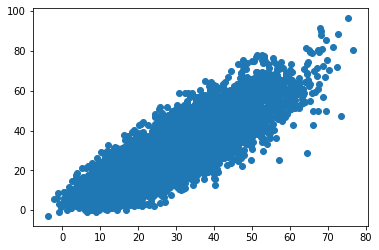

In [946]:
plt.scatter(pred, y_test)

**Data Visualizations**

In [689]:
import seaborn as sns

In [ ]:
bool_arr = master_dataset['Date'] == '2018-12-27'
X_train = m_default_final[bool_arr == False]
y_train = y[bool_arr == False]
X_test = m_default_final[bool_arr]
y_test = y[bool_arr]

In [701]:
lr = LinearRegression(fit_intercept=True, normalize=False)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
lr.score(X_test, y_test)

0.7898713772262076

In [702]:
mean_squared_error(pred, y_test)

47.62680729927138

Below we have plotted predicted fan duel points, designated by the x axis, along with actual fanduel points scored, designated by the y axis. For example, if it was predicted that a player would scored 20 points, he would actually score 10 FanDuel points. 

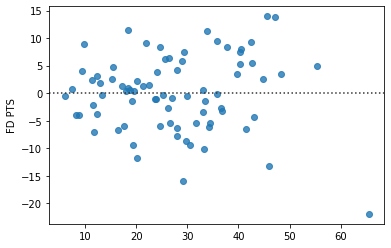

In [693]:
sns.residplot(pred, y_test);

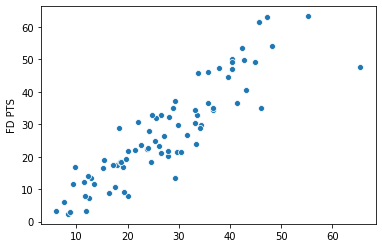

In [696]:
sns.scatterplot(pred,y_test)

In [87]:
years = player_found_dataset.groupby('AGE').apply(np.mean)
years.head()

,PLAYER_ID,TEAM_ID,PLAYER_GAME_ID,Salary,BMI,MIN,PTS,FGM,FGA,FG_PCT,...,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,FD PTS,BMI
AGE,,,,,,,,,,,,,,,,,,,,,
19.0,1.628224e+06,1.610613e+09,31.087879,4139.393939,22.616931,26.427273,9.690909,3.621212,9.030303,0.393545,...,99.845455,0.497509,0.147445,0.540033,19.0,7.406061,80.524242,208.815152,18.941818,22.616931
20.0,1.628353e+06,1.610613e+09,36.461918,5178.465753,23.563782,27.028493,12.095342,4.527671,10.100274,0.446004,...,100.351781,0.495642,0.146180,0.551167,20.0,11.310137,79.298082,211.164384,24.014356,23.563782
21.0,1.516608e+06,1.610613e+09,49.196078,5255.673417,23.868592,26.557056,11.951141,4.544519,9.747027,0.466344,...,99.947927,0.501305,0.144508,0.553556,21.0,14.606557,80.094503,218.121826,24.276406,23.868592
22.0,1.348230e+06,1.610613e+09,58.734659,5343.906655,24.205503,27.041775,12.695477,4.745895,10.229329,0.462277,...,99.361855,0.499741,0.145270,0.554827,22.0,19.636416,79.449726,217.735811,24.703140,24.205503
23.0,1.080843e+06,1.610613e+09,65.322181,5198.166819,24.519611,26.372365,11.833639,4.500229,9.575160,0.467442,...,99.250229,0.498820,0.144347,0.550816,23.0,21.189505,79.597388,221.469982,24.307470,24.519611


In [88]:
m_default_graph = m_default

We wanted to see if a player's age had an effect on how well they perform and how many FanDuel points they earn. We plotted this information below to visualize the trend. It's noticed that players between the ages of 25 and 30 earn the most points on average.

Text(0, 0.5, 'FD Points')

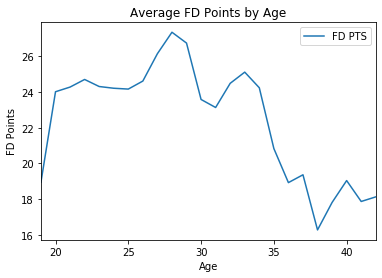

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

agemean = years.plot('AGE','FD PTS')

agemean.set_title('Average FD Points by Age')

agemean.set_xlabel('Age')

agemean.set_ylabel('FD Points')

Salaries are an important factor when drafting players in FanDuel. We wanted to explore if age had any effect to the draft cost of a player. We plotted this information below and learned that the most expensive players are also between 25-30 years old. It could very well be this is because this same age range earns the most points. 

Text(0, 0.5, 'Salary')

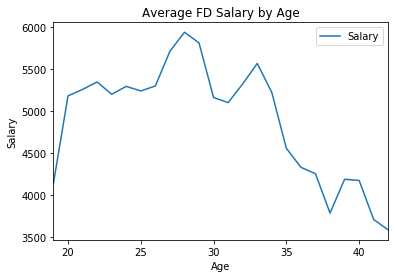

In [90]:
agemean = years.plot('AGE','Salary')

agemean.set_title('Average FD Salary by Age')

agemean.set_xlabel('Age')

agemean.set_ylabel('Salary')

In [91]:
DraftPick = player_found_dataset.groupby('DRAFT_NUMBER').apply(np.mean)
DraftPick

,PLAYER_ID,TEAM_ID,PLAYER_GAME_ID,Salary,BMI,MIN,PTS,FGM,FGA,FG_PCT,...,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,AGE,DRAFT_NUMBER,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,FD PTS,BMI
DRAFT_NUMBER,,,,,,,,,,,,,,,,,,,,,
1,5.164603e+05,1.610613e+09,91.933102,8851.585728,25.050929,33.934093,21.367691,8.033697,16.068385,0.504848,...,99.737364,0.500054,0.140418,0.561889,26.197225,1.0,80.391972,230.916254,40.801090,25.050929
2,5.269648e+05,1.610613e+09,88.433685,6249.242772,24.758420,29.357503,14.773749,5.618173,11.809087,0.475578,...,99.858651,0.501673,0.139846,0.558005,26.842129,2.0,80.180817,226.637907,28.759293,24.758420
3,4.839132e+05,1.610613e+09,91.150608,7167.795139,25.090214,30.251302,17.589410,6.349826,13.293403,0.484848,...,99.068142,0.501393,0.143108,0.562354,26.697049,3.0,80.384115,230.995660,33.204253,25.090214
4,3.611854e+05,1.610613e+09,79.874297,6534.798160,23.777014,28.719469,14.568217,5.312724,11.853347,0.454704,...,98.910577,0.497959,0.141574,0.555725,26.754216,4.0,78.826776,210.314768,29.791926,23.777014
5,4.635980e+05,1.610613e+09,80.463530,5558.581355,24.856791,26.063444,12.785067,4.582650,10.209322,0.443775,...,99.151489,0.498230,0.143255,0.555228,28.533017,5.0,78.736729,220.152784,26.006603,24.856791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,6.339286e+04,1.610613e+09,81.416129,4588.064516,24.185302,24.554839,8.967742,3.570968,7.119355,0.494071,...,97.980645,0.506645,0.142600,0.562274,35.922581,57.0,81.096774,226.677419,21.271613,24.185302
58,1.025405e+06,1.610613e+09,12.807692,3576.923077,24.122961,20.980769,8.423077,3.096154,7.307692,0.427519,...,100.423077,0.506731,0.135615,0.549846,25.596154,58.0,77.576923,206.788462,15.507692,24.122961
59,1.628417e+06,1.610613e+09,8.000000,3588.235294,24.165625,22.352941,5.823529,2.352941,5.294118,0.439118,...,95.352941,0.482588,0.134235,0.527176,25.000000,59.0,80.000000,220.000000,14.041176,24.165625


Next we wanted to visualize if higher drafted players cost more. From our data, it tends to be the case that the number 1 pick is more expensive, however there doesn't seem to be a significant relationship between draft pick positions and salaries. 

In [92]:
DraftPick['DRAFT_NUMBER'] = DraftPick['DRAFT_NUMBER'].astype(int)

Text(0, 0.5, 'Salary')

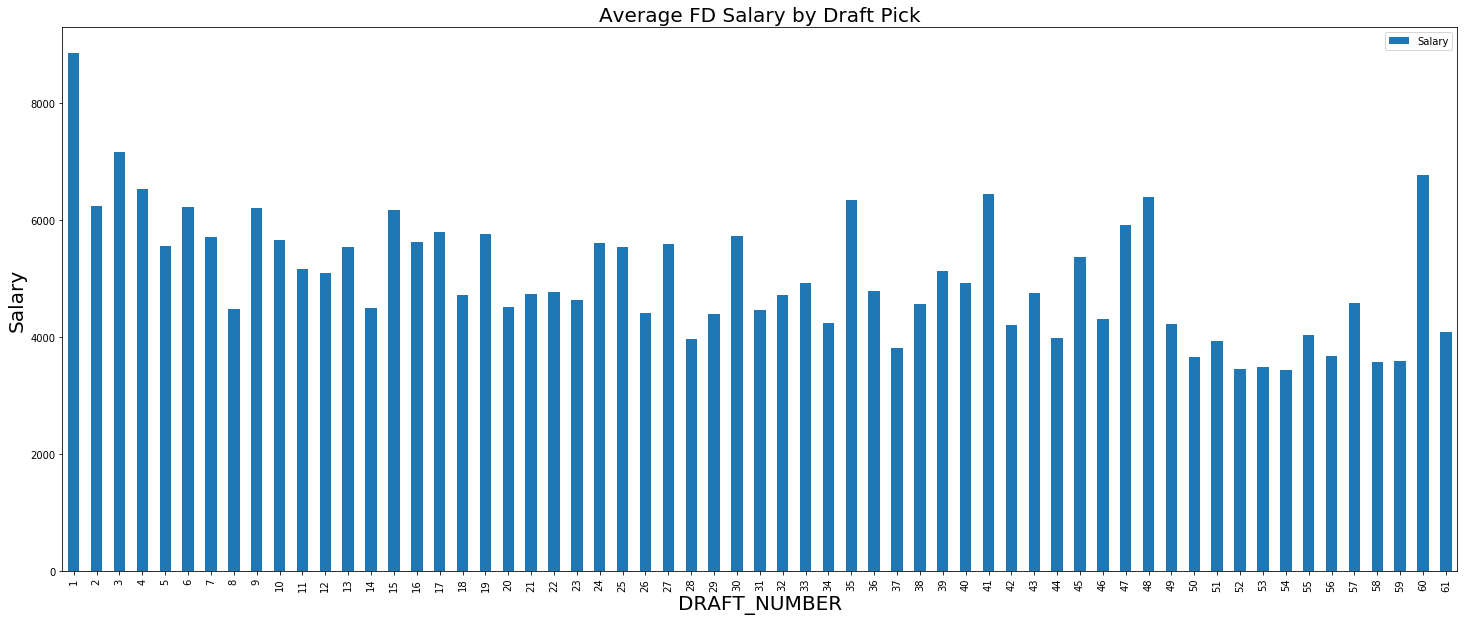

In [93]:
DraftMean = DraftPick.plot.bar('DRAFT_NUMBER','Salary', figsize = (25,10))
DraftMean.set_title('Average FD Salary by Draft Pick', fontsize = 20)
DraftMean.set_xlabel('DRAFT_NUMBER', fontsize = 20)
DraftMean.set_ylabel('Salary', fontsize = 20)

Another area we chose to explore was the impact a player's height has on the FanDuel points earned. Because different positions suite different heights of players, there doesn't seem to be a clear trend between height and points earned. 

Text(26.200000000000017, 0.5, 'Points')

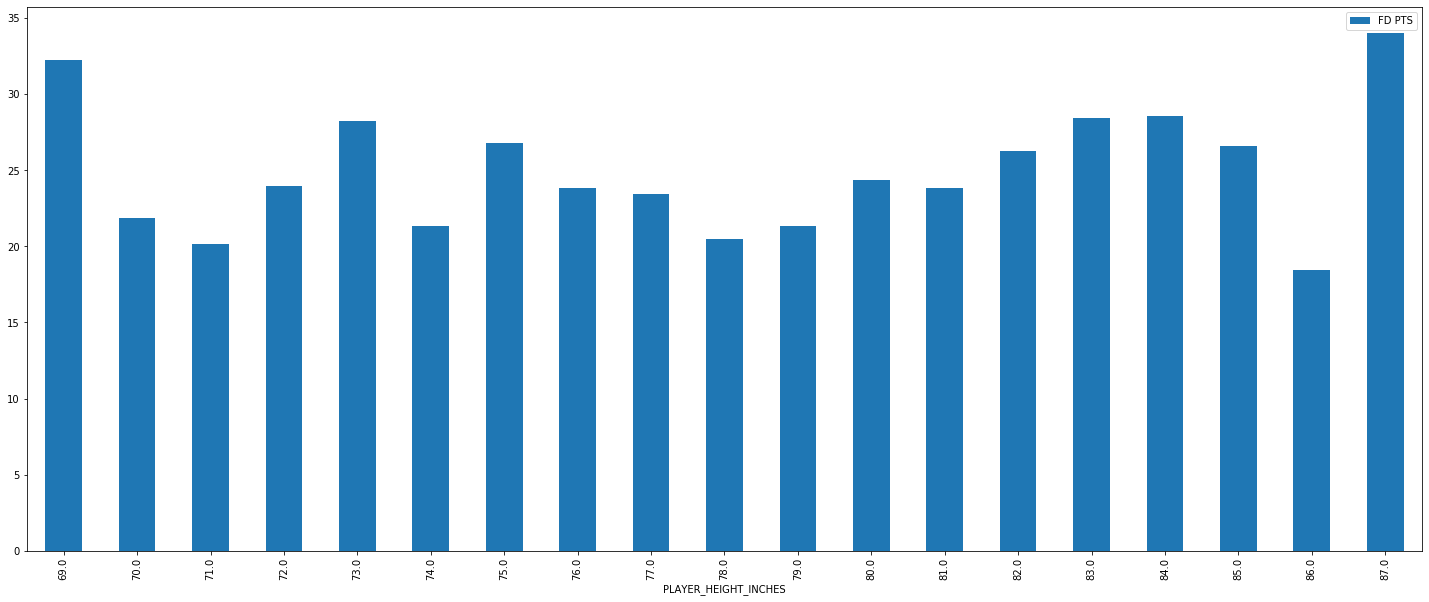

In [94]:
Height = player_found_dataset.groupby('PLAYER_HEIGHT_INCHES').apply(np.mean)
HeightGraph = Height.plot.bar('PLAYER_HEIGHT_INCHES','FD PTS', figsize = (25,10))
DraftMean.set_title('Average Points by Height', fontsize = 20)
DraftMean.set_xlabel('Height', fontsize = 20)
DraftMean.set_ylabel('Points', fontsize = 20)


Next, we wanted to see whether expensive players are actually worth their salary. By viewing the relationship between points scored in the last 10 games and corresponding salary, we see that there is a clear relationship between the two variables. This indicates that more expensive players tend to earn the most FanDuel points. 

In [95]:
SalaryMean = m_default.groupby('Salary').apply(np.mean)


In [96]:
m_default.groupby('FD PTS_LAST_10').apply(np.mean)

,PLAYER_ID,TEAM_ID,Salary,MIN,AGE,DRAFT_NUMBER,BMI,BMI,Home?,PTS_LAST_5,...,BLK_LAST_5,TOV_LAST_5,FD PTS_LAST_5,FD PTS_LAST_10,PTS_LAST_10,Position_C,Position_PF,Position_PG,Position_SF,Position_SG
FD PTS_LAST_10,,,,,,,,,,,,,,,,,,,,,
-2.80,2.564000e+03,1.610613e+09,3500.0,19.0,35.000000,21.0,27.460938,27.460938,0.0,0.000000,...,0.0,4.000000,-2.80,-2.80,0.000000,0.0,1.000000,0.0,0.000000,0.000000
-1.00,1.629019e+06,1.610613e+09,3600.0,16.0,23.000000,61.0,23.713948,23.713948,1.0,6.600000,...,0.0,1.800000,10.50,-1.00,2.000000,0.0,0.000000,0.0,0.000000,1.000000
0.00,6.777747e+05,1.610613e+09,3500.0,16.0,27.333333,61.0,24.989340,24.989340,1.0,0.666667,...,0.0,0.666667,0.00,0.00,0.666667,0.0,0.333333,0.0,0.333333,0.333333
0.20,1.628975e+06,1.610613e+09,3500.0,26.0,23.000000,32.0,25.162162,25.162162,1.0,4.400000,...,0.4,1.000000,11.38,0.20,0.000000,1.0,0.000000,0.0,0.000000,0.000000
0.20,1.627789e+06,1.610613e+09,3500.0,15.0,22.000000,24.0,23.687541,23.687541,0.0,0.000000,...,0.0,1.000000,0.20,0.20,0.000000,0.0,0.000000,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71.92,2.019350e+05,1.610613e+09,13900.0,39.0,29.000000,3.0,26.085343,26.085343,1.0,42.000000,...,1.4,5.000000,66.40,71.92,45.400000,0.0,0.000000,0.0,0.000000,1.000000
72.90,2.019350e+05,1.610613e+09,11200.0,38.0,27.000000,3.0,26.085343,26.085343,0.0,41.000000,...,0.0,1.000000,72.90,72.90,41.000000,0.0,0.000000,0.0,0.000000,1.000000
76.90,2.030760e+05,1.610613e+09,10800.0,40.0,24.000000,1.0,25.817826,25.817826,1.0,45.000000,...,2.0,1.000000,76.90,76.90,45.000000,0.0,1.000000,0.0,0.000000,0.000000


We wanted to look at how accurate our model is on a given day, in this plot we randomly chose December 12, 2018. 
The X axis is their average FanDuel points in their last 5 games, and the Y axis is their FanDuel point performance
that night. It can be seen that the data is fairly correlated.

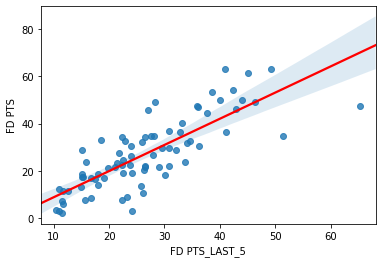

In [97]:


bool_arr = master_dataset['Date'] == '2018-12-14'

AvgLast5 = sns.regplot(X_test['FD PTS_LAST_5'], y_test)
regline = AvgLast5.get_lines()[0]
regline.set_color('red')

The boxplot below depicts our predicted FanDuel points versus actual FanDuel points earned. Overall, our predictions cover a lower range of points scored between the first and third quartile, with a higher predicted median. This could be due to the highly volatile nature of the NBA and professional sports. With many variables such injuries, personal reasons to missing games, break out (large scoring games), and career high games, it can be very challenging to make a fully accurate prediciton regarding player performance.  

In [98]:
Box = pd.DataFrame({'Predicted':pred,'Actual':y_test})

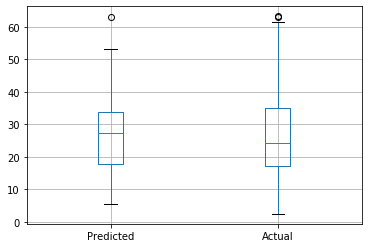

In [99]:
boxplot =Box.boxplot(column=['Predicted','Actual'])

### Conclusion
	
    Looking at the data that we received from our testing, we are able to be fairly accurately predict on how well a player will perform on a given night if we look at the actual performance of the player. The accuracy is a bit below actual performance on a given night, but we believe that to be fine as sports results may not be 100% predicted as many variables may change how the game will end. For example, a player may get injured during the game and our prediction would be off. Overall, a player that has previously played well will continue to play at a high level unless circumstances prevent it.

